In [1]:
# !pip install numpy==1.19.5
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Rice Disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2517 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Rice___Brown_Spot',
 'Rice___Healthy',
 'Rice___Leaf_Blast',
 'Rice___Neck_Blast']

In [6]:
len(dataset)

79

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 0 1 2 3 0 1 0 1 0 0 2 0 1 0 3 2 2 3 1 1 2 3 2 1 2 0 3 2 0 1]


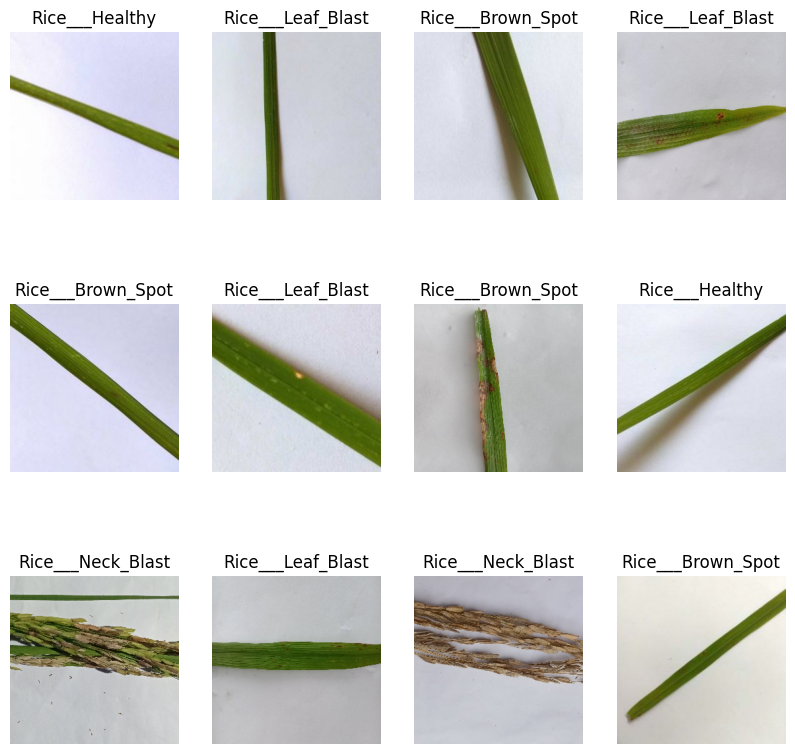

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

63.2

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

63

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])


In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
63/63 [==============================] - 54s 441ms/step - loss: 1.0908 - accuracy: 0.4211 - val_loss: 0.8310 - val_accuracy: 0.5714
Epoch 2/50
63/63 [==============================] - 14s 217ms/step - loss: 0.8495 - accuracy: 0.5362 - val_loss: 0.8238 - val_accuracy: 0.6071
Epoch 3/50
63/63 [==============================] - 14s 220ms/step - loss: 0.8043 - accuracy: 0.5764 - val_loss: 0.7913 - val_accuracy: 0.6205
Epoch 4/50
63/63 [==============================] - 14s 225ms/step - loss: 0.7476 - accuracy: 0.6364 - val_loss: 0.9942 - val_accuracy: 0.6518
Epoch 5/50
63/63 [==============================] - 14s 226ms/step - loss: 0.6731 - accuracy: 0.7009 - val_loss: 0.6429 - val_accuracy: 0.7232
Epoch 6/50
63/63 [==============================] - 14s 226ms/step - loss: 0.6508 - accuracy: 0.7207 - val_loss: 0.7839 - val_accuracy: 0.7143
Epoch 7/50
63/63 [==============================] - 13s 204ms/step - loss: 0.6750 - accuracy: 0.7128 - val_loss: 0.7279 - val_accuracy: 0.6429

In [21]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 12s 57ms/step - loss: 0.3859 - accuracy: 0.8542


In [22]:
scores

[0.38586193323135376, 0.8541666865348816]

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

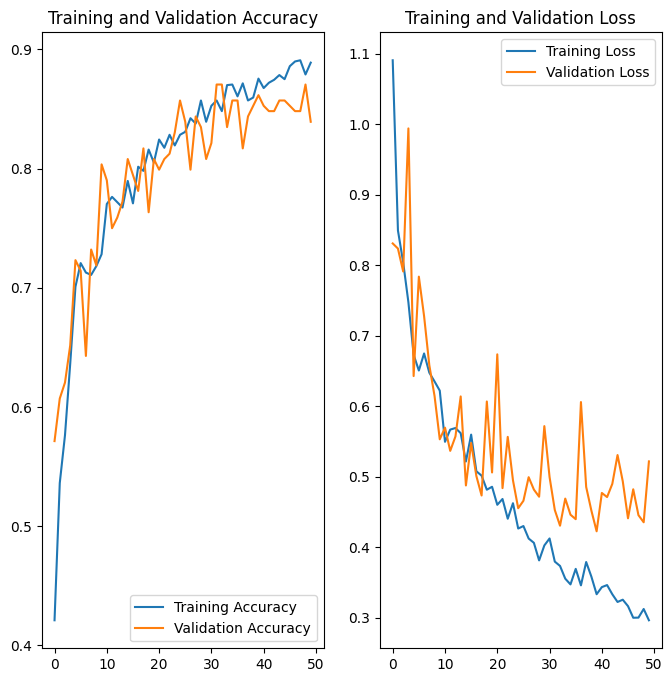

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Rice___Leaf_Blast
1/1 [==============================] - 0s 283ms/step
predicted label: Rice___Leaf_Blast


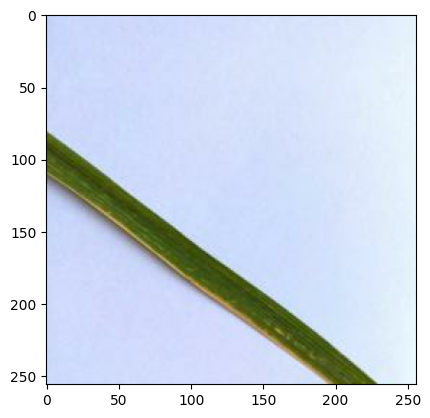

In [25]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [27]:
# plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        # ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        # plt.axis("off")
        print(f"actual_class {actual_class}, predicted_class {predicted_class}, confidence {confidence}")

1/1 [==============================] - 1s 714ms/step
actual_class Rice___Leaf_Blast, predicted_class Rice___Leaf_Blast, confidence 67.86
1/1 [==============================] - 0s 35ms/step
actual_class Rice___Leaf_Blast, predicted_class Rice___Leaf_Blast, confidence 93.05
1/1 [==============================] - 0s 40ms/step
actual_class Rice___Healthy, predicted_class Rice___Healthy, confidence 82.24
1/1 [==============================] - 0s 35ms/step
actual_class Rice___Neck_Blast, predicted_class Rice___Neck_Blast, confidence 100.0
1/1 [==============================] - 0s 42ms/step
actual_class Rice___Leaf_Blast, predicted_class Rice___Brown_Spot, confidence 97.37
1/1 [==============================] - 0s 30ms/step
actual_class Rice___Neck_Blast, predicted_class Rice___Neck_Blast, confidence 100.0
1/1 [==============================] - 0s 32ms/step
actual_class Rice___Healthy, predicted_class Rice___Leaf_Blast, confidence 61.69
1/1 [==============================] - 0s 32ms/step
actu

In [28]:
model.save("./rice.h5")